In [1]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3"

llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)

In [2]:
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env file

True

In [3]:
class AgentState(TypedDict):
    messages : Annotated[list, operator.add]

## Agent Node

In [4]:
## Tool Usage
import my_tools

# my_weather_tool = ToolNode.from_function()

# my_tools.get_weather.invoke({'location': 'New York'})

my_tools.calculate.invoke({'expression': '2+2'})

all_tools = [my_tools.get_weather, my_tools.calculate]

[TOOL] calculate ('2+2') -> '4'


In [5]:
def agent_node(state: AgentState) -> str:
    llm_with_tools = llm.bind_tools(all_tools)
    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] called Tool: {tc.get('name','?')} with args: {tc.get('args','?')}")
    else:
        print(f"[AGENT] Responding ...")

    return {'messages': [response]}


In [6]:
state = {"messages": [HumanMessage("Hi, what is 2+2")]}
result = agent_node(state)
result

[AGENT] called Tool: calculate with args: {'expression': '2 + 2'}


{'messages': [AIMessage(content='<think>\nOkay, the user asked, "Hi, what is 2+2". Let me see. They want to know the result of 2 plus 2. Looking at the tools provided, there\'s a calculate function that handles mathematical expressions. The function requires an expression argument using standard Python operators. Since the user\'s query is a straightforward arithmetic problem, I should use the calculate tool. The expression here is "2 + 2", so I\'ll call the function with that expression. No need for any other tools since it\'s a simple calculation. Let me make sure I format the tool call correctly in JSON within the XML tags.\n</think>\n\n', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-12-27T14:55:05.552737Z', 'done': True, 'done_reason': 'stop', 'total_duration': 14876043333, 'load_duration': 76262791, 'prompt_eval_count': 468, 'prompt_eval_duration': 5562201459, 'eval_count': 154, 'eval_duration': 9235680250, 'message': Message(role='assistant', con

## Routing

In [7]:
def should_continue(state: AgentState):
    last = state['messages'][-1]

    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    else:
        return END


In [8]:
## Graph

def create_agent():
    builder = StateGraph(AgentState)
    builder.add_node("agent", agent_node)
    builder.add_node("tools",ToolNode(all_tools))

    builder.add_edge(START, "agent")
    builder.add_conditional_edges("agent",should_continue,["tools", END])
    builder.add_edge("tools", "agent")

    graph = builder.compile()

    return graph
    


In [9]:
agent = create_agent()
agent

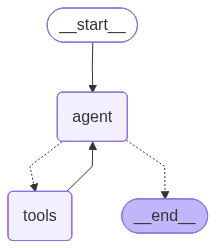

In [10]:
display(Image(agent.get_graph().draw_mermaid_png()))

In [11]:
agent.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'agent': Node(id='agent', name='agent', data=agent(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'tools': Node(id='tools', name='tools', data=tools(tags=None, recurse=True, func_accepts_config=True, func_accepts={'writer': False, 'store': True}, tools_by_name={'get_weather': StructuredTool(name='get_weather', description='Get current weather for a location.\n\n    Use for queries about weather, temperature, or conditions in any city.\n    Examples: "weather in Paris", "temperature in Tokyo", "is it raining in London"\n\n    Args:\n        location: City name (e.g., "New York", "London", "Tokyo")\n\n    Returns:\n        Current weather information including temperature and conditions.', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather

In [12]:
query = "What is the current weather in Kolkata?"
result = agent.invoke({'messages':[HumanMessage(query)]})

[AGENT] called Tool: get_weather with args: {'location': 'Kolkata'}
[AGENT] Responding ...


In [13]:
result

{'messages': [HumanMessage(content='What is the current weather in Kolkata?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="<think>\nOkay, the user is asking for the current weather in Kolkata. Let me check which tool to use. The available tools are get_weather and calculate. Since the query is about weather, I should use get_weather. The parameters require a location, which is Kolkata here. So I need to call get_weather with location set to Kolkata. No other parameters are needed. Just make sure the location name is correctly spelled as per the function's requirement. Alright, that's all.\n</think>\n\n", additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-12-27T14:55:13.588865Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7477011708, 'load_duration': 60022500, 'prompt_eval_count': 468, 'prompt_eval_duration': 256566542, 'eval_count': 120, 'eval_duration': 7159571583, 'message': Message(role='assistant', content="<think>\nOkay,

In [14]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

<think>
Okay, the user asked for the weather in Kolkata, and I tried to use the get_weather function. But there was a connection timeout error. Hmm, maybe the API at wttr.in is down or unreachable. Let me check the function's parameters again. The function requires a location, which I provided as Kolkata. Wait, maybe the issue is with the external service, not the function itself. Since I can't resolve the timeout, I should inform the user that the weather information couldn't be retrieved right now and suggest they try again later. Alternatively, check if there's another way to get the weather, but given the tools provided, I can't use another function. So the best response is to apologize and explain the timeout issue.
</think>

I'm currently unable to retrieve the weather information for Kolkata due to a connection timeout error. The weather service I'm using (wttr.in) might be temporarily unreachable.

In [15]:
query = "What is the current weather in Kolkata? and what is 11*21 and 45/3.4"
result = agent.invoke({'messages':[HumanMessage(query)]})

[AGENT] called Tool: get_weather with args: {'location': 'Kolkata'}
[AGENT] called Tool: calculate with args: {'expression': '11 * 21'}
[AGENT] called Tool: calculate with args: {'expression': '45 / 3.4'}
[TOOL] calculate ('11 * 21') -> '231'
[TOOL] calculate ('45 / 3.4') -> '13.23529411764706'
[AGENT] Responding ...


In [16]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

<think>
Okay, let me see. The user initially asked for three things: the weather in Kolkata, 11*21, and 45/3.4. I made three tool calls, but the first one for weather failed with a connection error. Then, the next two tool responses came back with the results for the calculations. Now, the user is responding with "231" and "13.235...", which are the results of the calculations. But since the weather call failed, I need to handle that.

Wait, the user's last message shows the tool responses. The first tool call (get_weather) had an error, so maybe the system tried to call it again? Or perhaps the user is simulating the tool responses. The user then provided the results for the calculations, which were 231 and 13.235... So, the user is probably expecting me to compile the answers, including the weather part even though there was an error. But since the error occurred, maybe I should mention that the weather